<a href="https://colab.research.google.com/github/Adeola23/google-colab/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "ade0laa" # username from the json file
os.environ['KAGGLE_KEY'] = "a5b589fc5c30f6bd592c3ade9c062a74" # key from the json file
!kaggle datasets download -d nikitarom/planets-dataset # api copied from kaggle



 98% 1.47G/1.50G [00:22<00:00, 65.8MB/s]
100% 1.50G/1.50G [00:22<00:00, 70.5MB/s]


In [ ]:
!unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_551.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fil

In [3]:
import pandas as pd
df_train = pd.read_csv("/content/planet/planet/train_classes.csv")
df_test = pd.read_csv("/content/planet/planet/sample_submission.csv")
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.models import Sequential
import os
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam, SGD
import tensorflow as tf




from tqdm import tqdm
from keras import optimizers

from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import time

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]

labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))


In [6]:
print(labels)

['clear', 'cloudy', 'primary', 'conventional_mine', 'blooming', 'haze', 'blow_down', 'water', 'road', 'artisinal_mine', 'selective_logging', 'habitation', 'slash_burn', 'bare_ground', 'cultivation', 'agriculture', 'partly_cloudy']


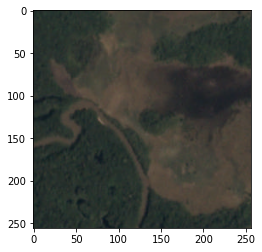

In [7]:
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
image_number =10
img = io.imread('/content/planet/planet/train-jpg/train_{}.jpg'.format(image_number))
plt.imshow(img)

In [8]:
len(labels)

17

In [9]:
df_trains = df_train.copy()

In [10]:
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [11]:
for tag in labels:
    df_trains[tag] = df_trains['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
df_trains['image_name'] = df_trains['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
df_trains.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [12]:
y_col = list(df_trains.columns[2:])

In [21]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [57]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=df_trains, \
        directory='/content/planet/planet/train-jpg', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training',rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, vertical_flip = True, fill_mode="nearest", featurewise_center = True)

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=df_trains, \
        directory='/content/planet/planet/train-jpg', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [58]:
optimizer = SGD(lr =0.01, momentum=0.9)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in model.layers[0].layers[1:]:
    layer.trainable = True

for layer in model.layers[0].layers:
    print(layer.name, layer. trainable)

    base_model.get_layer('block5_conv1').trainable = True
    base_model.get_layer('block5_conv2').trainable = True
    base_model.get_layer('block5_conv3').trainable = True
    base_model.get_layer('block5_pool').trainable = True

    
    model = Sequential([
    base_model,
  
   
 
    Flatten(), 
        
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.2),
    Dense(17, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])
model.summary()

input_10 False
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
Model: "sequential_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_208 (Flatten)        (None, 8192)              0         
_________________________________________________________________
dense_416 (Dense)            (None, 128)               1048704   
_________________________________________________________________
dropout_208 (Dropout)        (None, 128)               0         
________________________________________________

In [48]:
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [53]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [59]:
model.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=50, callbacks=[save_best_check_point], verbose = 1)

Epoch 1/50
253/253 [==============================] - 92s 364ms/step - loss: 0.2235 - fbeta: 0.7026 - val_loss: 0.1602 - val_fbeta: 0.7596
Epoch 2/50
253/253 [==============================] - 92s 364ms/step - loss: 0.1611 - fbeta: 0.7830 - val_loss: 0.1452 - val_fbeta: 0.7987
Epoch 3/50
253/253 [==============================] - 92s 365ms/step - loss: 0.1473 - fbeta: 0.8107 - val_loss: 0.1385 - val_fbeta: 0.8099
Epoch 4/50
253/253 [==============================] - 92s 362ms/step - loss: 0.1393 - fbeta: 0.8231 - val_loss: 0.1318 - val_fbeta: 0.8379
Epoch 5/50
253/253 [==============================] - 92s 363ms/step - loss: 0.1338 - fbeta: 0.8326 - val_loss: 0.1331 - val_fbeta: 0.8306
Epoch 6/50
253/253 [==============================] - 92s 365ms/step - loss: 0.1315 - fbeta: 0.8389 - val_loss: 0.1238 - val_fbeta: 0.8427
Epoch 7/50
253/253 [==============================] - 92s 363ms/step - loss: 0.1260 - fbeta: 0.8466 - val_loss: 0.1266 - val_fbeta: 0.8397
Epoch 8/50
253/253 [=======

In [62]:
model.load_weights('best_model.hdf5')

In [63]:
df_test1 = df_test.copy()
df_test1['image_name'] = df_test1['image_name'].apply(lambda x: '{}.jpg'.format(x))
df_test1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [64]:
test1_df = df_test1.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [65]:
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='/content/planet/planet/test-jpg', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [66]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = model.predict(test_gen1, steps=step_test_size1, verbose=1) 

318/318 [==============================] - 97s 304ms/step


In [88]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result4 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result4.head(20)

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary
5,test_5.jpg,clear primary
6,test_6.jpg,agriculture clear habitation primary road
7,test_7.jpg,clear habitation primary road
8,test_8.jpg,clear primary
9,test_9.jpg,agriculture haze primary


In [89]:
test2_df = df_test1.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [90]:
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='/content/test-jpg-additional/test-jpg-additional', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [76]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
pred2 = model.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

161/161 [==============================] - 49s 304ms/step


In [91]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,agriculture partly_cloudy primary road
2,file_10.jpg,clear primary road water
3,file_100.jpg,clear primary water
4,file_1000.jpg,clear primary


In [92]:
final_result = pd.concat([result4, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [93]:
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [95]:
final_result.to_csv('submission3.csv', index=False) # saving the predictions